# Next word predictor

### Importing the necessary libraries

In [1]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pickle
import matplotlib.pyplot as plt

2025-10-25 16:57:51.100524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761411471.345994      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761411471.407871      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading the dataset

In [2]:
try:
    with open('/kaggle/input/jungle-book/jungle_book.txt', 'r', encoding='utf-8') as file:
        text = file.read()
except FileNotFoundError:
    print("File not found. Ensure 'jungle_book.txt' is uploaded to Kaggle.")
    exit()
print(f"Sample text (first 200 characters): {text[:200]}")

Sample text (first 200 characters): ﻿It was seven o’clock of a very warm evening in the Seeonee hills when
Father Wolf woke up from his day’s rest, scratched himself, yawned, and
spread out his paws one after the other to get rid of the


### Cleaning the text

In [3]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\']', '', text)  
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_text = clean_text(text)
print(f"Cleaned text sample:\n {cleaned_text[:200]}")

Cleaned text sample:
 it was seven oclock of a very warm evening in the seeonee hills when father wolf woke up from his days rest scratched himself yawned and spread out his paws one after the other to get rid of the sleep


### Tokenizing the text

In [4]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-.:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([cleaned_text])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"Sample word-to-index mapping: {dict(list(word_index.items())[:5])}")

Vocabulary size: 5055
Sample word-to-index mapping: {'the': 1, 'and': 2, 'of': 3, 'to': 4, 'a': 5}


### Creating input and output sequence

In [5]:
sequence_length = 5
words = cleaned_text.split()
sequences = []
next_words = []

for i in range(len(words) - sequence_length):
    for j in range(1, sequence_length + 1):
        if i + j < len(words):
            seq = words[i:i + j]
            next_word = words[i + j]
            sequences.append(seq)
            next_words.append(next_word)

assert len(sequences) == len(next_words), f"Mismatch: len(sequences)={len(sequences)}, len(next_words)={len(next_words)}"
print(f"Sample sequence: {sequences[:5]} -> Next words: {next_words[:5]}")
print(f"Number of sequences: {len(sequences)}, Number of next words: {len(next_words)}")

Sample sequence: [['it'], ['it', 'was'], ['it', 'was', 'seven'], ['it', 'was', 'seven', 'oclock'], ['it', 'was', 'seven', 'oclock', 'of']] -> Next words: ['was', 'seven', 'oclock', 'of', 'a']
Number of sequences: 253635, Number of next words: 253635


### Converting word to token sequences

In [6]:
x = tokenizer.texts_to_sequences(sequences)
y = tokenizer.texts_to_sequences([next_words])[0]

### Padding sequences

In [7]:
valid_pairs = [(x_seq, y_id) for x_seq, y_id in zip(x, y) if len(x_seq) > 0 and y_id != 0]
if not valid_pairs:
    raise ValueError("No valid sequences after tokenization. Check tokenizer or data.")
x, y = zip(*valid_pairs)
x = list(x)
y = list(y)

In [8]:
assert len(x) == len(y), f"Tokenization mismatch: len(X)={len(x)}, len(y)={len(y)}"
print(f"After filtering - Number of sequences: {len(x)}, Number of next words: {len(y)}")

x = pad_sequences(x, maxlen=sequence_length, padding='pre')
y = np.array(y)
print(f"Shape of X: {x.shape}")
print(f"Shape of y: {y.shape}")
print(f"Sample X[0]: {x[0]} -> Sample y[0]: {y[0]}")

After filtering - Number of sequences: 253353, Number of next words: 253353
Shape of X: (253353, 5)
Shape of y: (253353,)
Sample X[0]: [ 0  0  0  0 18] -> Sample y[0]: 11


### Building the model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1761411488.954792      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761411488.955552      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5, 128)         │       647,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5055)           │       652,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,907,007 (7.27 MB)

 Trainable params: 1,907,007 (7.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


I0000 00:00:1761411495.526879      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


6334/6334 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.0664 - loss: 6.5211 - val_accuracy: 0.0678 - val_loss: 7.1239 - learning_rate: 0.0010
Epoch 2/500
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.0667 - loss: 6.3053 - val_accuracy: 0.0678 - val_loss: 7.3663 - learning_rate: 0.0010
Epoch 3/500
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.0670 - loss: 6.3044 - val_accuracy: 0.0678 - val_loss: 7.4613 - learning_rate: 0.0010
Epoch 4/500
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.0663 - loss: 6.3037 - val_accuracy: 0.0678 - val_loss: 7.4765 - learning_rate: 0.0010
Epoch 5/500
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.0670 - loss: 6.3033 - val_accuracy: 0.0678 - val_loss: 7.5236 - learning_rate: 0.0010
Epoch 6/500
6328/6334 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0665 - loss: 6.2963
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.0665 - lo

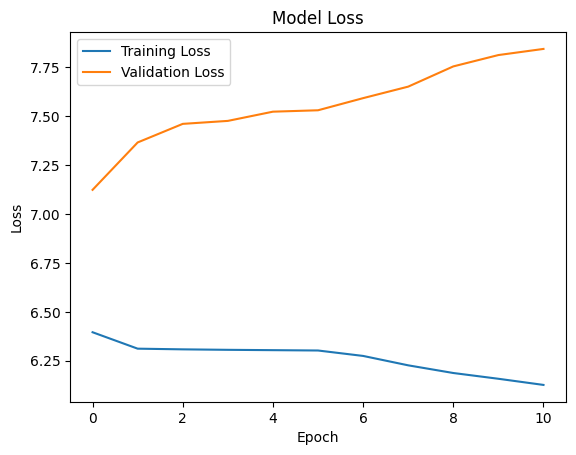

In [9]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_shape=(sequence_length,)))
model.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(LSTM(128, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(vocab_size, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Defining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# Train the model
history = model.fit(
    x, y,
    batch_size=32,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Saving the model

In [10]:
model.save('/kaggle/working/next_word_model.h5')
with open('/kaggle/working/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/kaggle/working/sequence_length.txt', 'w') as f:
    f.write(str(sequence_length))